# Intro to 4D-STEM data: Bragg disk detection



### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/1/2023, version 0.14.8

## Set up the environment

In [ ]:
import scipy as sp
import numpy as np
import matplotlib
import matplotlib as plt


# timestr used to create simple timestamps for easier version controll
import time
timestr = time.strftime("%Y%m%d")


# output dir for images,
import os
output_dir = 'output_images_' + timestr


import py4DSTEM

from py4DSTEM.visualize import show
py4DSTEM.__version__

---
# Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (501 megabytes)
* [Simulated single crystal and polycrystalline gold](https://drive.google.com/file/d/1m-jfXnStFWq0jo_hPY-3OtYaO62wHP3A/view?usp=drive_link)

# Load data

Load
- the same datacube as in the previous notebook, and 
- all the results produced in that notebook

In [36]:
# Load the .dm4 file from a workspace on OMNI or XNAS, set filepath with 'filepath_data = "FILEPATH"'
# even better, use dirpath'' and 'filepath_data', this makes it easier to add more paths later

dirpath = "/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/" #OMNI

filepath_data = dirpath + 'COPL_Ni65Cu35_C_ROI3_240827_aper_50_conv_1.5_spot_6_CL_47_stepsize_10_r_x_178_r_y_186_GIF_512x512_preprocessed_unfiltered_no_bin.h5'
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'


In [37]:
# Load the datacube

datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = 'dm_dataset_root/dm_dataset'
)

datacube

DataCube( A 4-dimensional array of shape (186, 178, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0,5,10,...] nm
              Ry = [0,5,10,...] nm
              Qx = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
              Qy = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
)

In [38]:
# Load the prior analysis

basics_01 = py4DSTEM.read(
    filepath_basics_01
)

basics_01.tree()

/
|---annular_dark_field
|---bright_field
|---dp_max
|---dp_mean
|---selected_area_diffraction_01
|---virt_dark_field_01


# Basic visualization

Show some of the data retrieved from the previous analysis

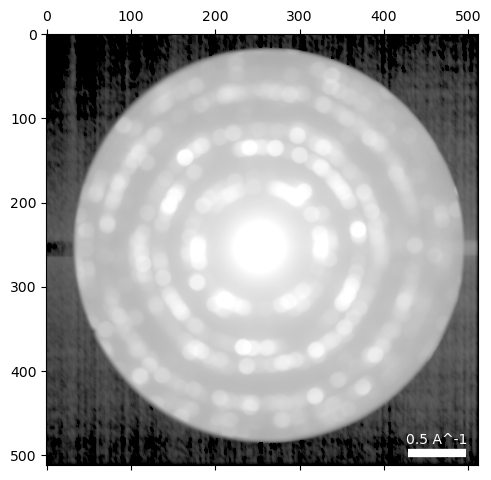

In [42]:
# Mean diffraction

show(
    basics_01.tree('dp_mean'),
    scaling='log',
)

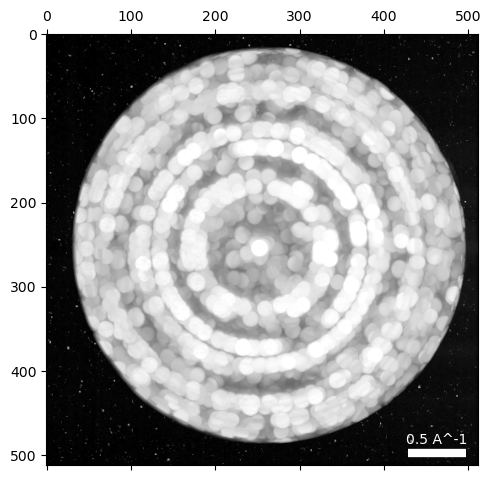

In [40]:
# Max diffraction

show(
    basics_01.tree('dp_max'),
    scaling='log',
)

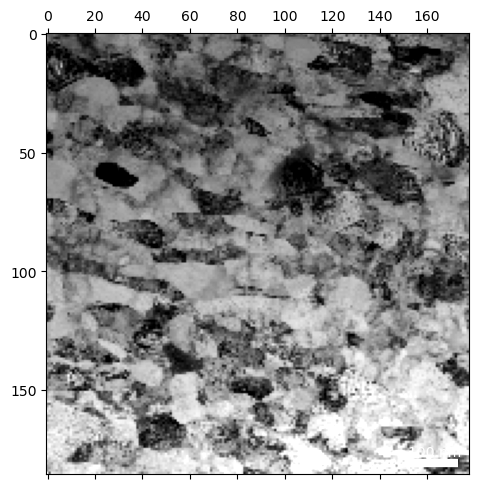

In [41]:
# Virtual BF

# show
show( basics_01.tree( 'bright_field' ) )

# Disk detection

We'll perform disk detection using template matching.  The mathematical machinery here is the cross correlation - if we compute the cross correlation of a template with an image, the maxima of the resulting correlogram correspond to the positions in the image that are good matches to the template.

The steps are:

1. Generate a template (the vacuum electron probe)
2. Prepare the template for cross correlation (generate a cross correlation kernel from the probe image)
3. Select a few scan position and test/refine parameters for the disk detection algorithm
4. Find all the disks

## Generage a probe template

There are a number of ways to get a probe.  If you're running an experiment, the best thing to do is to collect a separate dataset of the probe over vacuum.  It need not be large, but collecting at least a few or up to ~a hundred patterns to average over is useful.

Here, we'll select a region of the scan we have that's approximately over vacuum - it contains no gold particles, so only the thin amorphous support should be present - and use these scan positions to compute our probe.

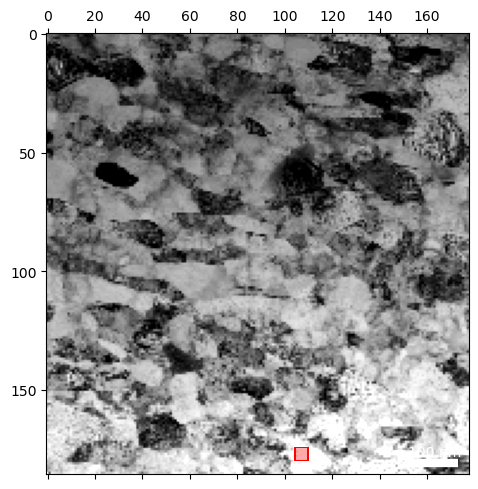

In [48]:
# select a vacuum region

import numpy as np
mask = np.zeros(datacube.Rshape,dtype=bool)
mask[175:180,105:110] = 1


show(
    basics_01.tree('bright_field'),
    mask = ~mask,
    mask_alpha = 0.667,
    mask_color = 'r'
)

100%|███████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.63it/s]


Warning, vmin not provided, setting minimum intensity = -61.38956158579464
Warning, vmax not provided, setting maximum intensity = 2055923.5677083333


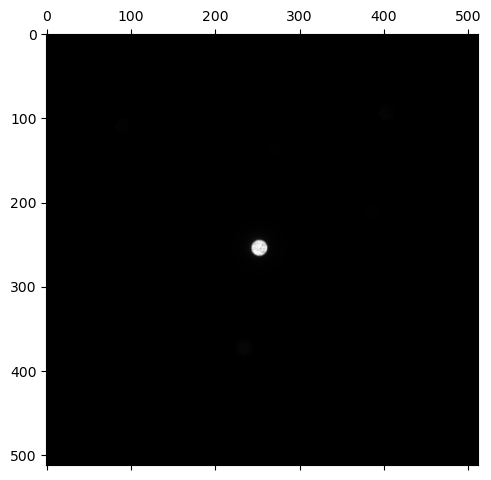

In [49]:
# generate a probe

probe = datacube.get_vacuum_probe( ROI=mask )

show(
    probe.probe,
    scaling='none',
    intensity_range='absolute'
)

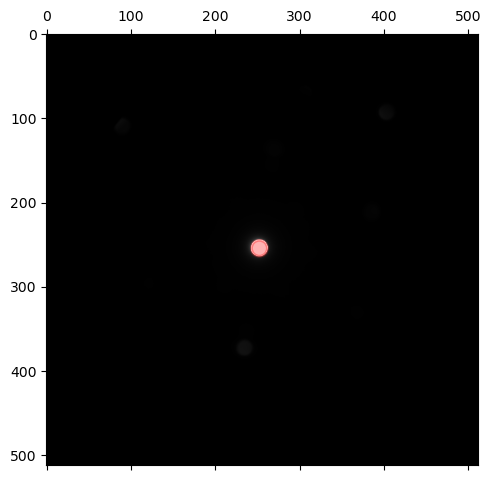

In [50]:
# Find the center and semiangle

alpha_pr,qx0_pr,qy0_pr = datacube.get_probe_size( probe.probe )

show(
    probe.probe, 
    scaling='none',
    intensity_range='absolute',
    vmin=0,vmax=7.2e5,
    circle = {
      'center':(qx0_pr,qy0_pr),
      'R': alpha_pr,
      'alpha':0.3,
      'fill':True
    }
)

The probe kernel is what we cross correlate each diffraction pattern with.  The simplest kernel would involve just shifting the vacuum probe to the origin.  However, disk detection is typically improved if we use a slightly more sophisticated kernel - one in which we carve out a narrow trench of negative intensity encircling the probe. This acts like an edge filter when we do template matching, helping "lock in" the template on the center each disk by penalizing template positions which are slightly offset.

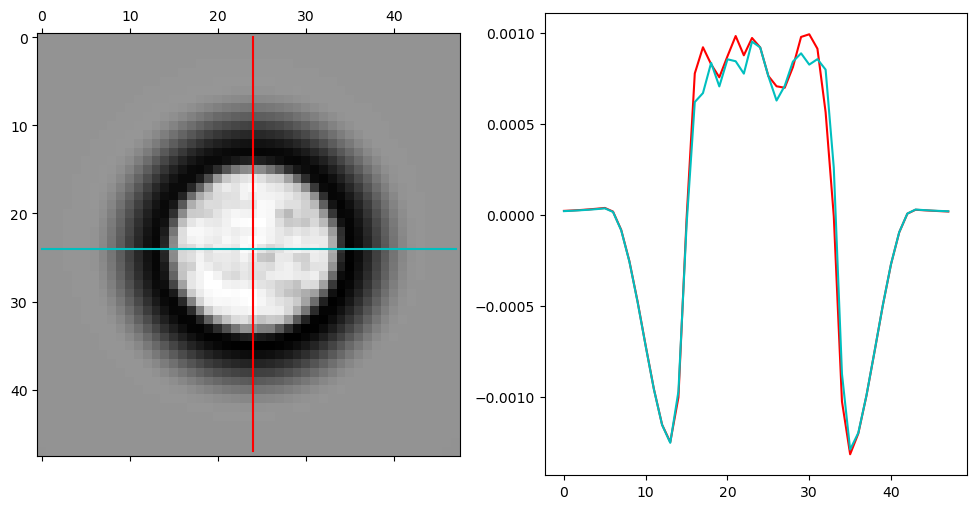

In [51]:
# prepare the probe kernel

probe.get_kernel(
    mode='sigmoid',
    origin=(qx0_pr,qy0_pr),
    radii=(alpha_pr,2*alpha_pr)   # the inner and outer radii of the 'trench'
)

fig, ax = py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1,
    returnfig = True
)

fig.savefig(os.path.join(output_dir, 'probe_kernel.pdf'), bbox_inches='tight')

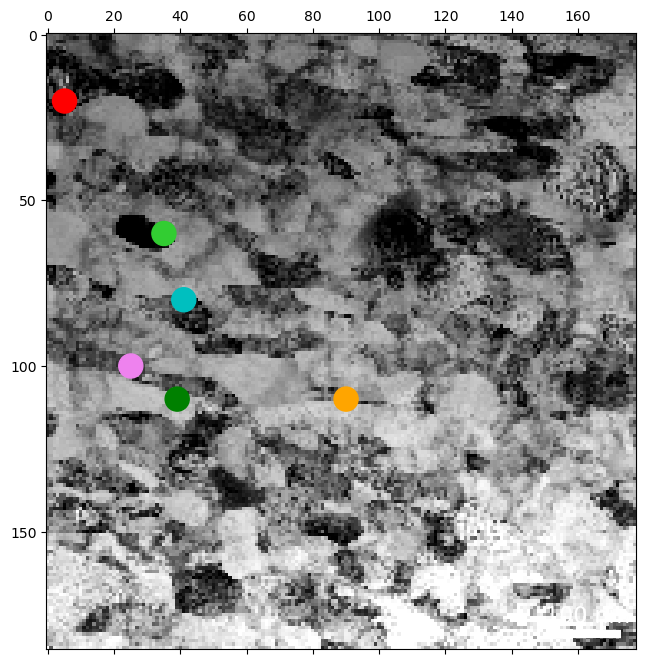

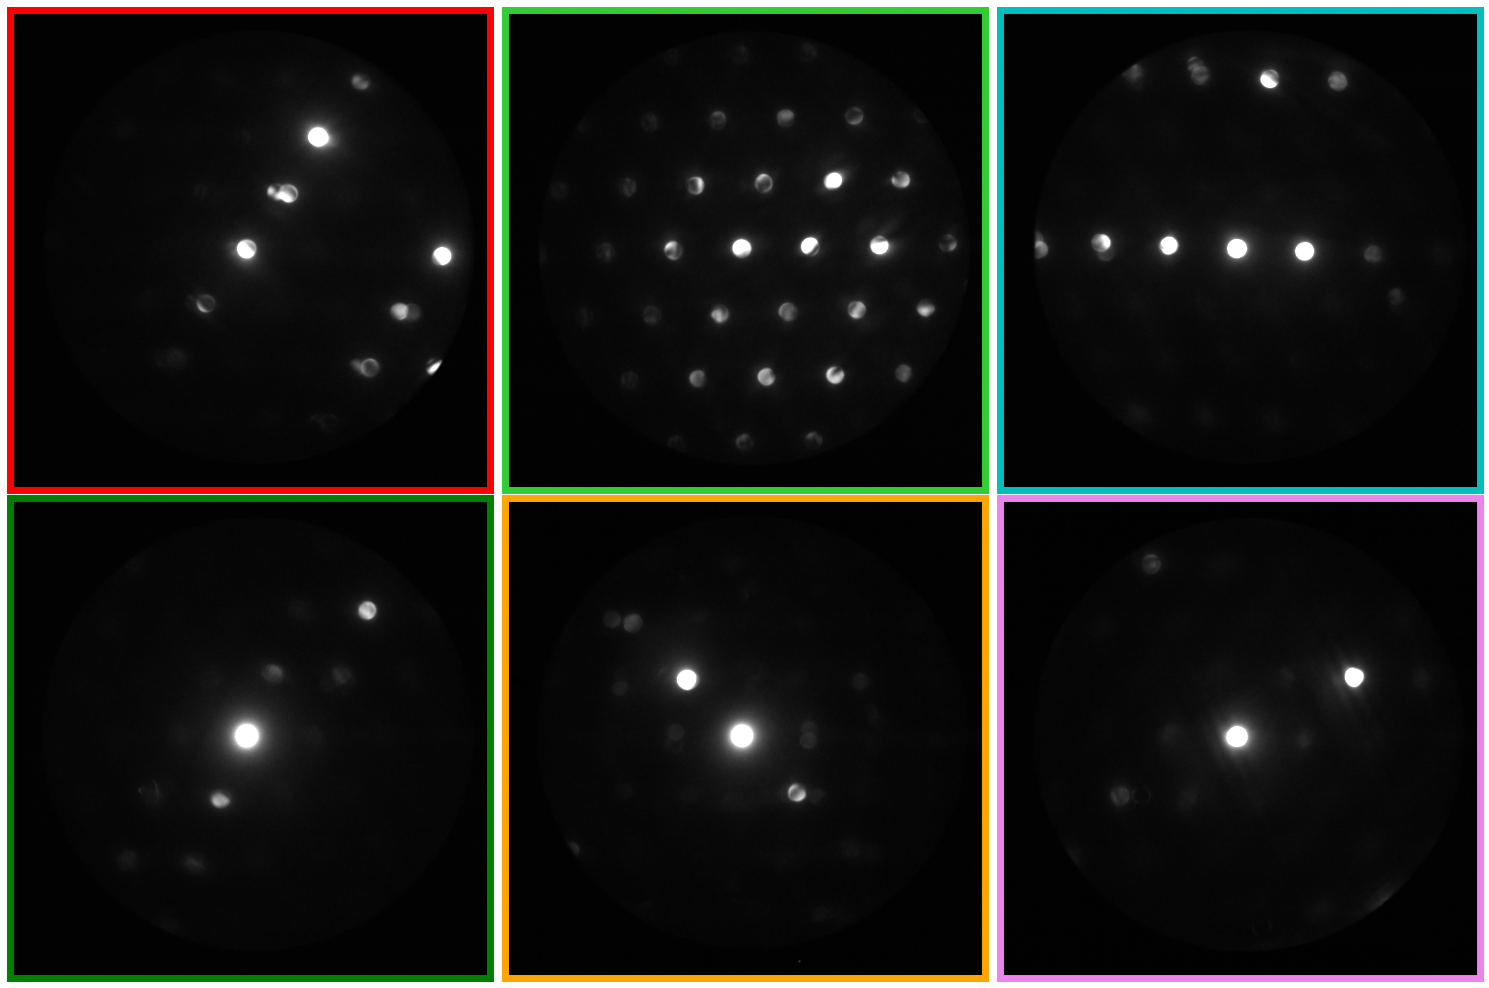

In [52]:
# Select a few sample patterns for parameter tuning


# choose scan positions

rxs = 20,60,80,110,110,100
rys = 5,35,41,39,90,25



# visualize

colors=['r','limegreen','c','g','orange', 'violet']

# show the selected
# positions in real space
fig, ax = py4DSTEM.visualize.show_points(
    basics_01.tree('bright_field'),
    x=rxs,
    y=rys,
    scale=300,
    pointcolor=colors,
    figsize=(8,8),
    returnfig = True
)

# save fig
fig.savefig(os.path.join(output_dir, 'show_points.pdf'), bbox_inches='tight')

# show the selected
# diffraction patterns
fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=1e5,
    scaling='power',
    power=0.75,
    get_bordercolor = lambda i:colors[i],
    returnfig = True
)

# save fig
fig.savefig(os.path.join(output_dir, 'image_grid.pdf'), bbox_inches='tight')

Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 771.37885
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 689.5209
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 600.7242
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1135.628
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 1148.3287
Warning, vmin not provided, setting minimum intensity = 0.0
Warning, vmax not provided, setting maximum intensity = 977.49677


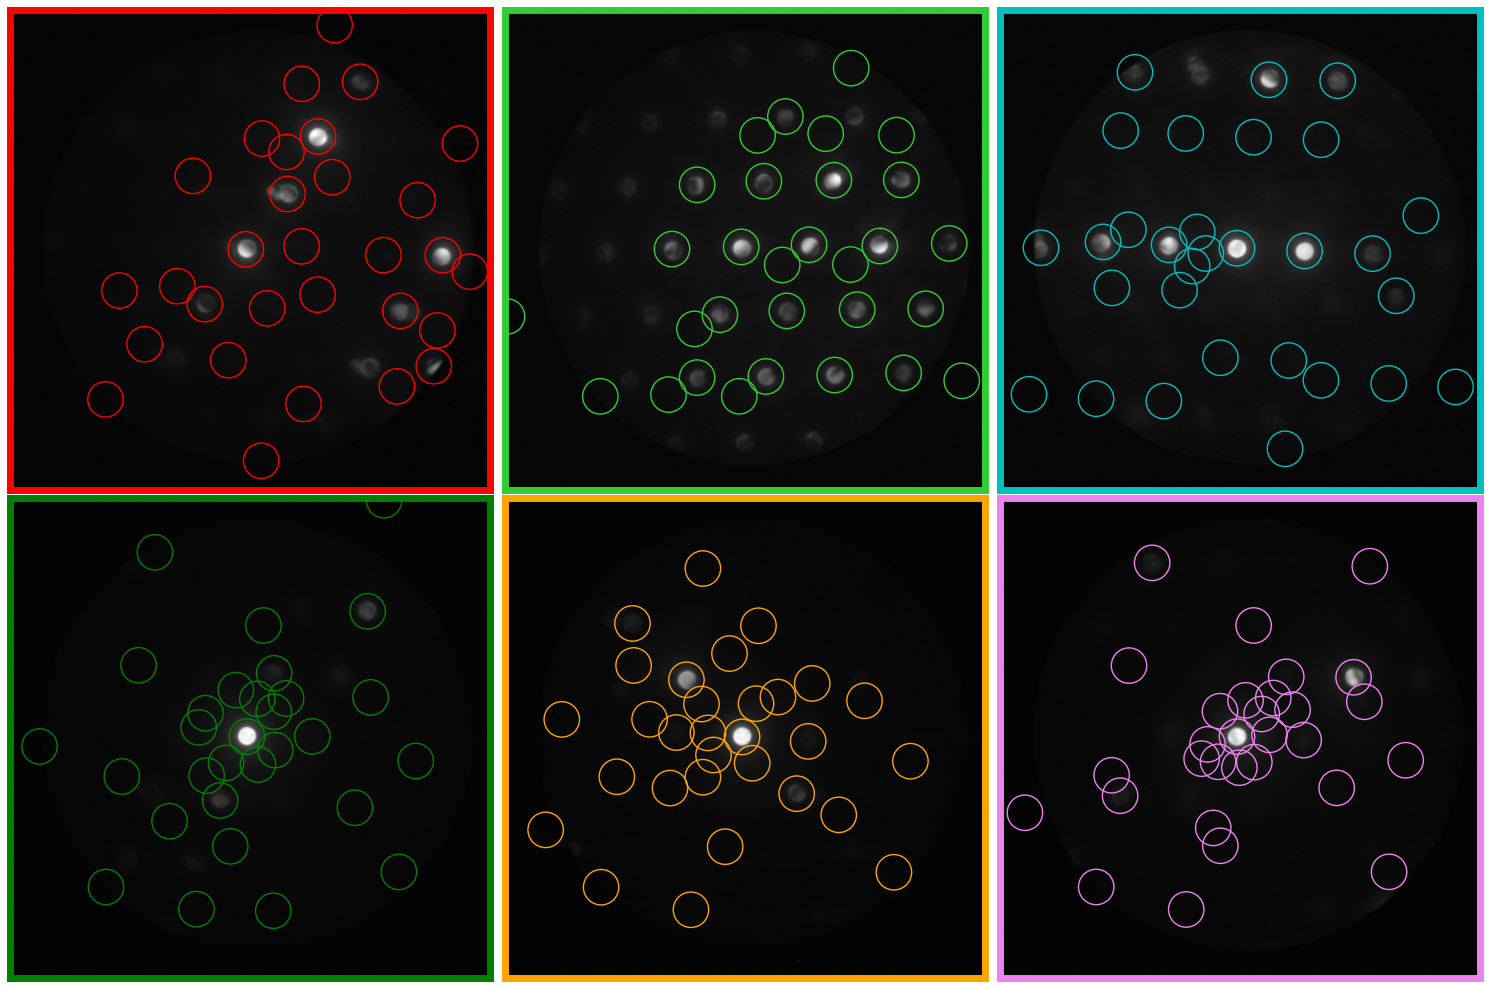

In [53]:
# Choose disk detection parameters


# set parameters

detect_params = {
    'minAbsoluteIntensity': 8,   # intensity threshold
    'minRelativeIntensity': 0,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 15,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 2,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 0.4,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 30,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'poly',         # subpixel resolution method
    'corrPower': 1.0,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
#     'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
}


# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 650,
    returnfig = True
)

# save fig
fig.savefig(os.path.join(output_dir, 'disc_detection.pdf'), bbox_inches='tight')

In [54]:
# compute for all diffraction patterns

braggpeaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|█████████████████████████████████████████| 33.1k/33.1k [11:56<00:00, 46.2DP/s]


Localizing the disks measures the Bragg points.  Just like the max and mean diffraction patterns allow us to get a succinct but highly informative picture of the whole dataset all at once, it's useful to condense all the information about Bragg scattering we just measured into a single visualization.  We do this with a Bragg vector map - a 2D histogram of all the Bragg vector positions and intensities we've measured.

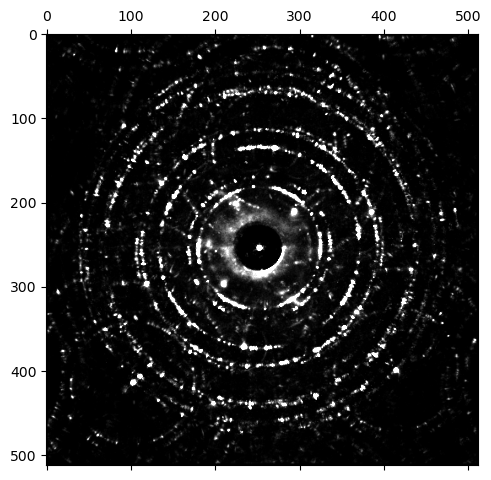

In [62]:
# Bragg vector map

# compute
bvm = braggpeaks.histogram( mode='raw' )

# show
show(bvm)

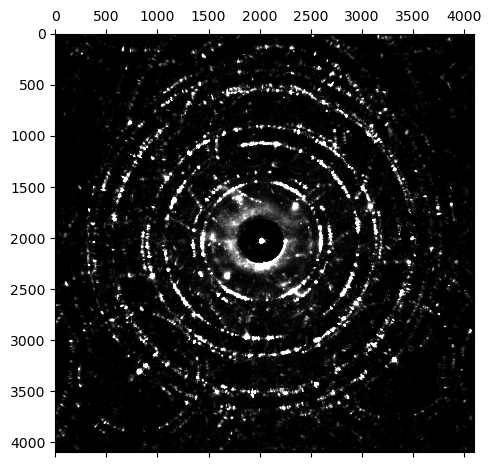

In [63]:
# Increasing the sampling can be helpful to visualize the resolution and error of our measurement.

# compute
bvm_upsampled = braggpeaks.histogram(
    mode='raw',
    sampling = 8
)

# show
show(bvm_upsampled)

# Write and read

In [64]:
# set a filepath

filepath_save = dirpath + 'analysis_basics_02.h5'
filepath_save

'/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/analysis_basics_02.h5'

In [65]:
# inspect what's in `datacube`'s  tree

datacube.tree()

/
|---probe
|---braggvectors


In [66]:
# save everthing except the datacube

py4DSTEM.save(
    filepath_save,
    datacube,
    tree = None,  # everything *under* datacube, but not not datacube itself
    mode = 'o'
)

100%|███████████████████████████████████████████████████████████| 33108/33108 [00:03<00:00, 9098.03it/s]


In [67]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(filepath_save)

/
|---dm_dataset_root
    |---braggvectors
    |   |---_v_uncal
    |---probe




In [68]:
# Load to confirm everything worked

basics_02 = py4DSTEM.read(
    filepath_save
)

basics_02.tree()

Reading PointListArray: 100%|████████████████████████████| 33108/33108 [00:05<00:00, 6236.77PointList/s]

/
|---braggvectors
|---probe
